Import necessary libraries

In [293]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps

from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, RandomTranslation, RandomRotation, RandomFlip
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from kerastuner.tuners import Hyperband

from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Load the image and label data and split into train and test sets

In [251]:
images = np.load('images.npy')
labels = np.load('labels.npy')

encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

NUM_CLASSES = labels.shape[1]

IMG_train, IMG_test, LBL_train, LBL_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Define and compile the CNN model with hyperparameters

In [252]:
def getCNNModel(hp):
    translation_factor = hp.Float('translation_factor', min_value=0.0, max_value=0.1, step=0.02)
    model = Sequential([
        Input(shape=(64, 64, 1)),
        RandomRotation(hp.Float('factor', min_value=0.0, max_value=0.05, step=0.01), fill_mode="constant", fill_value=255),
        RandomTranslation(height_factor=translation_factor, width_factor=translation_factor, fill_mode="constant", fill_value=255),
        # RandomFlip(),
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(hp.Int('conv_4_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.8, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

Define the Hyperparameter tuner

In [253]:
tuner = Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='cnn_tuning9')

Reloading Tuner from hyperband/cnn_tuning9/tuner0.json


Define the early stopping callback and begin the hyperparameter search

In [254]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(IMG_train, LBL_train, validation_split=0.2, callbacks=[stop_early], epochs=15, batch_size=64)

Print out the best hyperparameters

In [255]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'translation_factor': 0.0, 'factor': 0.01, 'conv_1_filters': 8, 'conv_2_filters': 64, 'conv_3_filters': 96, 'conv_4_filters': 192, 'dense_units': 512, 'dropout': 0.4, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


Build the best model using the hyperparameters and save it to disk

In [256]:
model = tuner.hypermodel.build(best_hps)
model.save('best_cnn_model.keras')

In [260]:
k = 3
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_history = []
val_accuracy = -1
best_model = None

for i, (train_idxs, val_idxs) in enumerate(kfold.split(IMG_train, LBL_train)):
    print(f"Fold {i + 1}/{k}")
    
    model = tuner.hypermodel.build(best_hps)
    
    history = model.fit(
        IMG_train[train_idxs],
        LBL_train[train_idxs],
        validation_data=(IMG_train[val_idxs], LBL_train[val_idxs]),
        epochs=30,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)
    
    if val_acc_per_epoch[-1] > val_accuracy:
        val_accuracy = val_acc_per_epoch[-1]
        best_model = model

Fold 1/3
Epoch 1/30
1068/1068 [==============================] - 34s 31ms/step - loss: 4.0150 - accuracy: 0.1499 - val_loss: 1.8299 - val_accuracy: 0.5695
Epoch 2/30
1068/1068 [==============================] - 33s 31ms/step - loss: 1.6591 - accuracy: 0.5613 - val_loss: 0.7951 - val_accuracy: 0.7903
Epoch 3/30
1068/1068 [==============================] - 33s 31ms/step - loss: 0.9601 - accuracy: 0.7329 - val_loss: 0.5264 - val_accuracy: 0.8561
Epoch 4/30
1068/1068 [==============================] - 33s 30ms/step - loss: 0.7012 - accuracy: 0.8001 - val_loss: 0.4275 - val_accuracy: 0.8802
Epoch 5/30
1068/1068 [==============================] - 32s 30ms/step - loss: 0.5441 - accuracy: 0.8422 - val_loss: 0.3518 - val_accuracy: 0.9015
Epoch 6/30
1068/1068 [==============================] - 32s 30ms/step - loss: 0.4502 - accuracy: 0.8693 - val_loss: 0.3170 - val_accuracy: 0.9099
Epoch 7/30
1068/1068 [==============================] - 33s 30ms/step - loss: 0.3810 - accuracy: 0.8878 - val_loss:

Plot Training Accuracy and Validation Accuracy of the CNN against Epochs

/tmp/ipykernel_5007/4255085200.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')


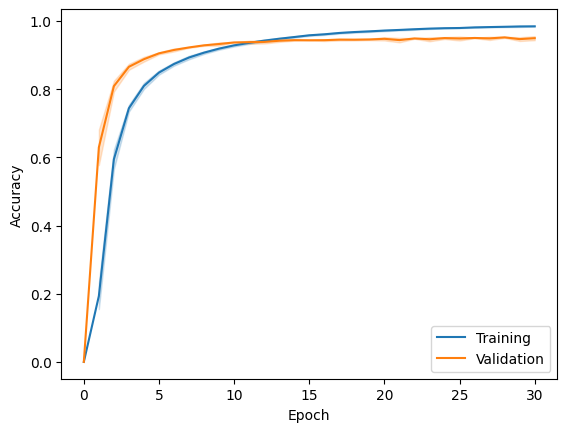

In [275]:
plt.figure()

df = pd.DataFrame(fold_history[0].history)

# Iterate through each dictionary and append to DataFrame
for i, history in enumerate(fold_history[1:]):
    df = pd.concat([df, pd.DataFrame(history.history)])

# Assuming df is your DataFrame with 'loss', 'accuracy', 'val_loss', 'val_accuracy'
# Reshape DataFrame to long format
df_long = df.reset_index().melt(id_vars='index', value_vars=['accuracy', 'val_accuracy'])
df_long.rename(columns={'index': 'Epoch', 'variable': 'Metric', 'value': 'Value'}, inplace=True)

df_long.loc[len(df_long)] = [-1, 'accuracy', 0]
df_long.loc[len(df_long)] = [-1, 'val_accuracy', 0]

df_long = df_long.replace({'val_accuracy': 'Validation', 'accuracy': 'Training'})



# Add 1 to all epoch values
df_long['Epoch'] = df_long['Epoch'] + 1

# Plotting
sns.lineplot(data=df_long, x='Epoch', y='Value', hue='Metric', ci='sd')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')

# Show the plot
plt.show()

The best tuned model is the cnn_model

In [276]:
cnn_model = best_model

In [ ]:
cnn_model: Sequential = load_model('best_cnn_model.keras')

In [278]:
feature_output = cnn_model.layers[-4].output 
feature_model = Model(inputs=cnn_model.input, outputs=feature_output)

train_features = feature_model.predict(IMG_train)
test_features = feature_model.predict(IMG_test)

801/801 [==============================] - 3s 4ms/step


In [279]:
print(train_features.shape)

(102528, 768)


In [280]:
# Convert from one-hot encoding to integer encoding
LBL_train_int = np.argmax(LBL_train, axis=1)
LBL_test_int = np.argmax(LBL_test, axis=1)

In [281]:
# Convert from integer encoding back to original labels
LBL_train_original = encoder.inverse_transform(LBL_train_int)
LBL_test_original = encoder.inverse_transform(LBL_test_int)

In [285]:
logistic_regressor = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=1)
logistic_regressor.fit(train_features, LBL_train_original)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       136882     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31278D+05    |proj g|=  8.88744D+03


 This problem is unconstrained.



At iterate   50    f=  9.68569D+02    |proj g|=  2.07020D+02

At iterate  100    f=  2.45208D+02    |proj g|=  5.87465D+00

At iterate  150    f=  2.25289D+02    |proj g|=  1.36540D+00

At iterate  200    f=  2.20072D+02    |proj g|=  1.78757D+00

At iterate  250    f=  2.19028D+02    |proj g|=  2.50865D-01

At iterate  300    f=  2.18836D+02    |proj g|=  1.05090D-01

At iterate  350    f=  2.18804D+02    |proj g|=  6.81185D-02

At iterate  400    f=  2.18797D+02    |proj g|=  1.96020D-02

At iterate  450    f=  2.18794D+02    |proj g|=  3.02119D-02

At iterate  500    f=  2.18788D+02    |proj g|=  5.45416D-02

At iterate  550    f=  2.18762D+02    |proj g|=  3.89032D-01

At iterate  600    f=  2.18627D+02    |proj g|=  1.55812D-01

At iterate  650    f=  2.18315D+02    |proj g|=  2.33443D-01

At iterate  700    f=  2.18102D+02    |proj g|=  3.19123D-01

At iterate  750    f=  2.18041D+02    |proj g|=  5.47709D-02

At iterate  800    f=  2.18029D+02    |proj g|=  5.90676D-02

At iter

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, verbose=1)

In [286]:
predictions = logistic_regressor.predict(test_features)

In [287]:
report = classification_report(LBL_test_original, predictions)
print(report)

              precision    recall  f1-score   support

           一       0.99      1.00      1.00       142
           七       0.95      0.94      0.94       143
           三       0.97      0.99      0.98       136
           上       0.98      0.95      0.97       133
           下       0.94      0.97      0.96       141
           不       0.96      0.94      0.95       151
           东       0.93      0.90      0.91       147
           个       0.98      0.98      0.98       151
           中       0.94      0.97      0.96       136
           么       0.94      0.97      0.95       140
           九       0.96      0.95      0.96       146
           习       0.96      0.97      0.96       155
           书       0.95      0.96      0.96       140
           买       0.97      0.94      0.95       143
           了       0.97      0.98      0.97       143
           二       0.98      0.97      0.98       148
           五       0.99      0.96      0.98       141
           些       0.96    

In [307]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [*range(3, 9, 2)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with the grid search
grid_search.fit(train_features, LBL_train_original)



# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn

Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best score: 0.9294534176029962


/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.91402349 0.92049977 0.91402349 0.92049977 0.92148486 0.92728816
 0.92148486 0.92728816 0.92456695 0.92945342 0.92456695 0.92945342
        nan 0.90914677        nan 0.90914677        nan 0.9157791
        nan 0.9157791         nan 0.91803215        nan 0.91803215
        nan 0.90914677 0.91402349 0.92049977        nan 0.9157791
 0.92148486 0.92728816        nan 0.91803215 0.92456695 0.92945342]
  warnings.warn(


In [308]:
# Define the KNN model with the best parameters
knn_model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                 weights=grid_search.best_params_['weights'],
                                 metric=grid_search.best_params_['metric'],
                                 p=grid_search.best_params_['p'])

# Fit the model with the training features and labels
knn_model.fit(train_features, LBL_train_original)

KNeighborsClassifier(metric='euclidean', n_neighbors=7, p=1, weights='distance')

In [310]:
# Create an instance of the KNN classifier
knn = KNeighborsClassifier(n_neighbors=7, metric="euclidean")

# Fit the classifier to the training data
knn.fit(train_features, LBL_train_original)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

In [311]:
# Predict the labels for the test data
knn_predictions = knn.predict(test_features)

In [312]:
report = classification_report(LBL_test_original, knn_predictions)
print(report)

              precision    recall  f1-score   support

           一       0.98      1.00      0.99       142
           七       0.88      0.94      0.91       143
           三       0.88      0.98      0.92       136
           上       0.94      0.95      0.94       133
           下       0.90      0.97      0.93       141
           不       0.92      0.95      0.93       151
           东       0.87      0.88      0.88       147
           个       0.93      0.98      0.95       151
           中       0.90      0.98      0.94       136
           么       0.77      0.99      0.87       140
           九       0.93      0.90      0.92       146
           习       0.90      0.99      0.94       155
           书       0.93      0.96      0.94       140
           买       0.92      0.92      0.92       143
           了       0.90      0.96      0.93       143
           二       0.93      0.97      0.95       148
           五       0.94      0.96      0.95       141
           些       0.96    

In [ ]:
def numpy_to_image(numpy_array):
    return Image.fromarray(numpy_array.astype('uint8'))

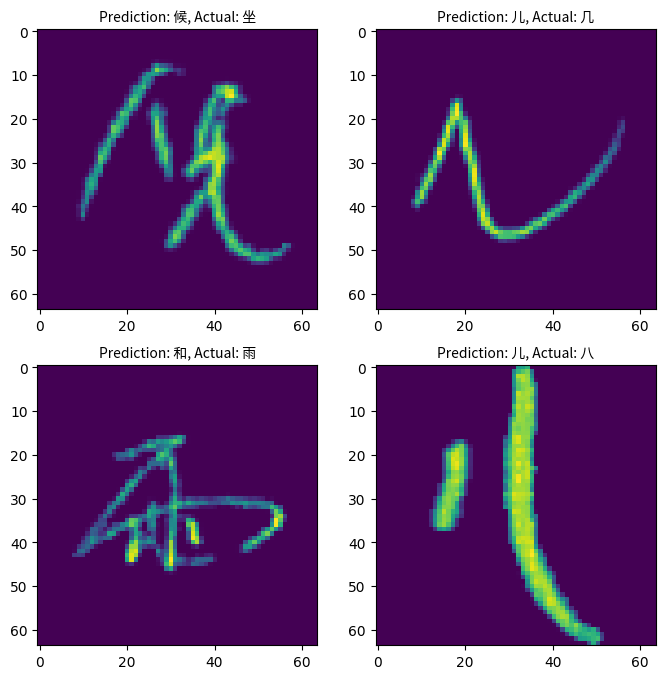

In [316]:
import random

# Get the indices of correct and wrong predictions
correct_indices = np.where(predictions == LBL_test_original)[0]
wrong_indices = np.where(predictions != LBL_test_original)[0]

correct_indices = random.sample(list(correct_indices), 4)
wrong_indices = random.sample(list(wrong_indices), 4)

correct_images = [IMG_test[idx] for idx in correct_indices]
wrong_images = [IMG_test[idx] for idx in wrong_indices]

correct_pred = (correct_indices, correct_images)
wrong_pred = (wrong_indices, wrong_images)

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for idxs, images in (wrong_pred, ):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(2):
        for j in range(2):
            idx = idxs[2 * i + j]
            numpy_image = images[2 * i + j]
            img = numpy_to_image(numpy_image)
            img = ImageOps.invert(img)
            axs[i][j].imshow(img)
            axs[i][j].set_title(f"Prediction: {predictions[idx]}, Actual: {LBL_test_original[idx]}",
                                fontproperties=prop,
                                fontsize = 13)


In [323]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.15, 0.3, 0.5]
}

# Create an instance of the SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, verbose=2, n_jobs=-1)

# Create a GridSearchCV object
grid_search = GridSearchCV(sgd_clf, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model with the training data
grid_search.fit(train_features, LBL_train_original)

# Make predictions on the test data
y_pred = grid_search.predict(test_features)

# Evaluate the model
accuracy = accuracy_score(LBL_test_original, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)



-- Epoch 13
Norm: 1870.78, NNZs: 678, Bias: -12.265132, T: 1179072, Avg. loss: 3.444774
Total training time: 92.79 seconds.
-- Epoch 24

Total training time: 53.76 seconds.
-- Epoch 20

Total training time: 1610.66 seconds.
-- Epoch 414
Norm: 1873.68, NNZs: 651, Bias: -2.893345, T: 4203648, Avg. loss: 0.878062
Total training time: 296.81 seconds.
-- Epoch 83
Norm: 283.25, NNZs: 155, Bias: -1.994231, T: 3691008, Avg. loss: 0.554036
Total training time: 203.59 seconds.
-- Epoch 73
Norm: 1892.72, NNZs: 660, Bias: -7.902955, T: 19890432, Avg. loss: 1.488460
Total training time: 1499.33 seconds.
-- Epoch 389
Norm: 1565.89, NNZs: 616, Bias: -5.283654, T: 7587072, Avg. loss: 1.740210
Total training time: 551.91 seconds.
-- Epoch 149
Norm: 476.51, NNZs: 464, Bias: -3.426644, T: 102528, Avg. loss: 1.455252
Total training time: 8.26 seconds.
-- Epoch 3
Norm: 989.68, NNZs: 526, Bias: -9.572795, T: 22248576, Avg. loss: 4.753038
Total training time: 1587.29 seconds.
-- Epoch 435
Norm: 279.45, NNZs

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 68.7min


Norm: 637.24, NNZs: 450, Bias: -3.382396, T: 6869376, Avg. loss: 1.395850Norm: 1672.16, NNZs: 661, Bias: -16.500237, T: 5639040, Avg. loss: 1.112085
Total training time: 397.11 seconds.
-- Epoch 111

Total training time: 176.19 seconds.
-- Epoch 46
Norm: 330.28, NNZs: 205, Bias: -1.748799, T: 2768256, Avg. loss: 1.614961
Total training time: 155.83 seconds.
-- Epoch 55
Norm: 447.43, NNZs: 290, Bias: -3.936671, T: 13533696, Avg. loss: 2.825340
Total training time: 816.36 seconds.
-- Epoch 265
Norm: 1987.02, NNZs: 662, Bias: -16.177588, T: 2255616, Avg. loss: 2.159199
Total training time: 174.86 seconds.
-- Epoch 45
Norm: 1837.02, NNZs: 654, Bias: -6.886529, T: 1486656, Avg. loss: 2.220712
Total training time: 104.40 seconds.
-- Epoch 30
Norm: 254.33, NNZs: 134, Bias: -1.581193, T: 3178368, Avg. loss: 1.219505Norm: 279.29, NNZs: 135, Bias: -1.006021, T: 7894656, Avg. loss: 1.249360Norm: 232.37, NNZs: 94, Bias: -1.205283, T: 3434688, Avg. loss: 1.317632
Total training time: 170.05 seconds

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 73.6min


Norm: 947.36, NNZs: 492, Bias: -8.179553, T: 15943104, Avg. loss: 3.881557
Total training time: 1020.33 seconds.
-- Epoch 312
Norm: 513.12, NNZs: 371, Bias: -5.283470, T: 8202240, Avg. loss: 1.436687Norm: 1977.28, NNZs: 669, Bias: -16.046245, T: 1589184, Avg. loss: 2.440249

Total training time: 334.80 seconds.
Convergence after 118 epochs took 334.80 seconds
Norm: 336.41, NNZs: 173, Bias: -0.569374, T: 4818816, Avg. loss: 1.179993Norm: 245.62, NNZs: 117, Bias: -1.083317, T: 6151680, Avg. loss: 0.816695
Total training time: 351.01 seconds.
-- Epoch 121
Norm: 1653.58, NNZs: 639, Bias: -8.208925, T: 5895360, Avg. loss: 2.589172
Total training time: 377.87 seconds.
-- Epoch 116


Total training time: 10.29 seconds.
-- Epoch 4
Total training time: 99.79 seconds.
-- Epoch 32
Norm: 1815.83, NNZs: 636, Bias: -8.321166, T: 9842688, Avg. loss: 1.444862
Total training time: 639.26 seconds.
-- Epoch 193
Norm: 2281.10, NNZs: 665, Bias: -11.799581, T: 3485952, Avg. loss: 4.850470Norm: 258.51, NNZs: